# GAN: Generative Adversarial Network

**topics:** main idea of GAN, architecture, optimization functional, training problems

**date:** 

**Author:** Artem Maksimovich Fedorov

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Дизайн и интуиция за GAN 

Мы хотим построить модель `генератор`, которая умеет порождать новые "правдоподобные" объекты $x$, опираясь на примеры из обучающей выборки $\mathcal{D} = \{ x_i \}$. Первая мысль, приходящая в голову в таком подходе – определить метрику реалистичности взятого объекта $x$, основывающуюся на $\mathcal{D}$:

- Для реальных объектов из $\mathcal{D}$ мы должны получать большие значения "реалистичности"
- Для плохих сгенеированных объектов – плохие показатели реалистичности
- Модель, генерирующая объекты, должна пытаться максимизировать данную метрику

Однако при попытка построить такую задачу возникают проблемы:

1) Не понятно, как определить такие конструктивные правила в сложных/комплексных доменах (картинки, тексты, звук и т. д.)
2) Как заставить модель генерировать разнообразные объекты: тривиальное решение данной задачи – выдавать поочередно $x_i \in \mathcal{D}$

Ключевая идея GAN: вместо того чтобы вручную формулировать такой набор правил, мы будем получать оценку качества нашего `генератора` через вторую модель, параллельно с генератором обучаемую отличать настоящие объекты от созданных – назовем ее `дискриминатором`. `Генератор` будет пытаться обмануть `дискриминатор`, `дискриминатор` будет пытаться разоблачить `генератор` – такая гонка вооружений должна привести к постепенному улучшению качестве генерации до уровня неотличимого от оригинальных.

## Аналогия идеи GAN с реальной жизнью

<p align="center">
  <img src="images/lecture_2/counterfeiter.png" style="width:60%;">
</p>


Рассмотрим ситуацию из реальной жизни: 

- **Фальшивомонетчик** делает поддельные банкноты и хочет, чтобы они проходили проверку. **Цель:** выпускать такие подделки, которые неотличимы от настоящих для проверяющего
- **Эксперт** получает банкноту и решает: настоящая она или поддельная. **Цель:** как можно лучше отличать подделки от настоящих.

Фальшивомонетчик не знает в силу своей неграмотности/неосведомленности всех правил, по которым производит проверку эксперт, однако он восстанавливает методологию подделки купюр из практики:

1) Эксперт получает все более качественные подделки вперемешку с реальными купюрами
2) За каждую подделку ему выдают штраф от начальства, что уже с точностью может определить реальность купюры.
3) Эксперту приходится все более аккуратно производить проверку купюр
4) Фальшивомонетчик получает обратную связь через результат проверки: какие купюры прошли проверку, какие нет
5) За каждую удачно принятую купюру он становится богаче, за кажду отвергнутую – беднее
6) Фальшивомонетчик вынужден улучшать качество, улучшая те качества объектов, что вынудили эксперта ошибиться

## Определение генератора

Пусть выборка $\mathcal{D}=\{x_i\}_{i=1}^n$ является реализацией выборки из распределения реальных объектов $x_i \sim p_{\text{data}}(x_i)$:

Чтобы модель `генератор` $G$ могла порождать **разнообразные** (недетерминированные) объекты, ей нужен источник случайности. Введём латентную переменную $z \sim \mathrm{Prior}(z)$, где $\mathrm{Prior}$ — простое конструктивное распределение, чаще всего $\mathcal U([-1,1]^d)$ или $\mathcal N(0,I)$ (обычно выбирают именно многомерное нормальное). Тогда генерация задаётся как
$$
\tilde{x}=G(z),\quad z\sim \mathcal N(0,I)
\Longrightarrow
\tilde{x}\sim p_g(\tilde{x}),
$$
где $p_g$ — распределение на $\mathcal X$, **индуцированное** отображением $G$ из prior-распределения. $\tilde{x}$ теперь можно рассматривать как случайную величину.


# Генеративные состязательные сети (GAN)

Будем считать, что для любого фиксированного генератора мы способны обучить идеальный дискриминатор (классификатор), который обозначим $D(x)$

Если считать $D$ фиксированным, то желание генератора “обмануть” дискриминатор можно записать как задачу минимизации:
$$
\min_{G}\; \mathbb{E}_{z \sim p(z)}\Big[\log\big(1 - D(G(z))\big)\Big].
$$

Казалось бы, получилась обычная задача оптимизации. Но здесь есть важный нюанс: **мы пока не определили, что именно означает “идеальный дискриминатор”**. Определим идеальный дискриминатор, как эксперта, что **лучше всех** отличает реальные объекты от сгенерированных. Тогда для фиксированного $G$ дискриминатор является решением задачи бинарной классификации:
$$
\max_{D}\;
\mathbb{E}_{x \sim p_{\text{data}}(x)}\big[\log D(x)\big]
+
\mathbb{E}_{z \sim p(z)}\Big[\log\big(1 - D(G(z))\big)\Big].
$$

Эта функция совпадает по смыслу с лог-правдоподобием (а с минусом — с кросс-энтропией) для классификатора “real vs fake”. Тем самым генератор “играет” против **наилучшего** дискриминатора для текущего $G$, и мы приходим к minimax-постановке:
$$
\min_{G}\max_{D}\;
\mathbb{E}_{x \sim p_{\text{data}}(x)}\big[\log D(x)\big]
+
\mathbb{E}_{z \sim p(z)}\Big[\log\big(1 - D(G(z))\big)\Big].
$$


<p align="center">
  <img src="images/lecture_2/saddle.png" style="width:60%;">
</p>

## Распределение генератора и идеальный дискриминатор для фиксированного $G$

Наша цель — добиться $p_g(x)\approx p_{\text{data}}(x)$. Проверим, что именно это мы получаем при решении поставленной задачи оптимизации

Найдём вид оптимального дискриминатора при фиксированном $G$. Перепишем функционал дискриминатора через $p_g$:
$$
\max_{D}\;
\mathbb{E}_{x \sim p_{\text{data}}}\big[\log D(x)\big]
+
\mathbb{E}_{z \sim p(z)}\big[\log(1 - D(G(z)))\big]
=
\max_{D}\;
\mathbb{E}_{x \sim p_{\text{data}}}\big[\log D(x)\big]
+
\mathbb{E}_{\tilde{x} \sim p_g}\big[\log(1 - D(\tilde{x}))\big]
$$

В интегральной форме это:
$$
\max_{D}\; \int \Big(p_{\text{data}}(x)\log D(x) + p_g(x)\log(1-D(x))\Big)\,dx.
$$

Так как $D(x)$ выбирается **покомпонентно** для каждого $x$, можно максимизировать выражение в скобках по $D(x)$. Производная по $D(x)$ равна нулю, когда:
$$
\frac{p_{\text{data}}(x)}{D(x)} - \frac{p_g(x)}{1-D(x)} = 0
\quad\Longrightarrow\quad
D_G^*(x)=\frac{p_{\text{data}}(x)}{p_{\text{data}}(x)+p_g(x)}, \text{ --- $D_G^*$ идеальный дискриминатор при фиксированном $G$}
$$

Если $p_{\text{data}} = p_g$ (что мы и хотим по дизайну задачи) $\Rightarrow$ тогда $D_G^*(x)=\frac{1}{2}$ для всех $x$: дискриминатор не может отличить real от fake и “угадывает” с вероятностью $1/2$.

## Приведенный функционал оптимизации

Подставляя оптимальный дискриминатор
$$
D_G^*(x)=\frac{p_{\text{data}}(x)}{p_{\text{data}}(x)+p_g(x)},\qquad
1-D_G^*(x)=\frac{p_g(x)}{p_{\text{data}}(x)+p_g(x)},
$$
в исходный функционал, получаем, что при *идеальном* классификаторе задача генератора эквивалентна
$$
V(D_G^*,G)=
\mathbb{E}_{x \sim p_{\text{data}}}\log \frac{p_{\text{data}}(x)}{p_{\text{data}}(x)+p_g(x)}
+
\mathbb{E}_{x \sim p_g}\log \frac{p_g(x)}{p_{\text{data}}(x)+p_g(x)}.
$$

Введём $m(x)=\frac{p_{\text{data}}(x)+p_g(x)}{2}$. Тогда

$$
\begin{align}
V(D_G^*,G)
&=
\mathbb{E}_{x \sim p_{\text{data}}}\log \frac{p_{\text{data}}(x)}{p_{\text{data}}(x)+p_g(x)}
+
\mathbb{E}_{x \sim p_g}\log \frac{p_g(x)}{p_{\text{data}}(x)+p_g(x)}\\
&=
\mathbb{E}_{x \sim p_{\text{data}}}\log \frac{p_{\text{data}}(x)}{2m(x)}
+
\mathbb{E}_{x \sim p_g}\log \frac{p_g(x)}{2m(x)}\\
&=
-\log 4
+
\underbrace{\mathbb{E}_{x \sim p_{\text{data}}}\log \frac{p_{\text{data}}(x)}{m(x)}}_{=\,KL(p_{\text{data}}\|m)}
+
\underbrace{\mathbb{E}_{x \sim p_g}\log \frac{p_g(x)}{m(x)}}_{=\,KL(p_g\|m)}\\
&=
-\log 4
+ KL\!\left(p_{\text{data}}\|m\right)
+ KL\!\left(p_g\|m\right).
\end{align}
$$




Заметим, что дивергенция Йенсена–Шеннона определяется как
$$
JSD(p_{\text{data}}\|p_g)=\frac{1}{2}KL\!\left(p_{\text{data}}\|m\right)+\frac{1}{2}KL\!\left(p_g\|m\right),
\qquad m=\frac{p_{\text{data}}+p_g}{2}.
$$

Следовательно, при идеальном дискриминаторе генератор решает
$$
-\log 4 + 2\,JSD(p_{\text{data}}\|p_g)\to \min_G,
$$
а минимум достигается при $p_g=p_{\text{data}}$ (тогда $JSD=0$ и $D_G^*(x)=\frac{1}{2}$).


## Итоговая схема обучения GAN

<p align="center">
  <img src="images/lecture_2/gan_diagram.png" style="width:60%;">
</p>


# Мой первый GAN

Рассмотрим максимально простой пример, где пространство объектов одномерное: $x \in \mathbb{R}$.  
Реальные данные получаются из смеси двух нормальных распределений:
$$
p_{\text{data}}(x)=\pi\,\mathcal{N}(\mu_1,\sigma_1^2) + (1-\pi)\,\mathcal{N}(\mu_2,\sigma_2^2),
$$
например, в экспериментах дальше:
$$
p_{\text{data}}(x)=0.7\,\mathcal{N}(-3,1^2)+0.3\,\mathcal{N}(3,1^2).
$$

Доступ к $p_{\text{data}}$ устроен так же, как в реальных задачах: у нас есть только выборка $x_i \sim p_{\text{data}}(x)$ (то есть мы умеем брать реальные примеры).


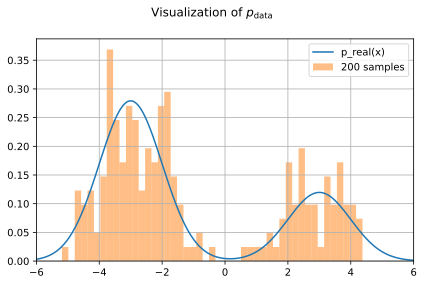

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

mixture_gaussian = torch.distributions.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([0.7, 0.3])),
    torch.distributions.Normal(
        loc=torch.tensor([-3., 3.]),
        scale=torch.tensor([1., 1.])
    )
)

def p_real(x: np.ndarray) -> np.ndarray:
    x_t = torch.tensor(x, dtype=torch.float32)
    return mixture_gaussian.log_prob(x_t).exp().numpy()

samples = mixture_gaussian.sample((200, 1)).numpy().flatten()

x = np.linspace(-6, 6, 400)
bins = np.linspace(-6, 6, 60)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, p_real(x), label="p_real(x)")
ax.hist(samples, bins=bins, density=True, alpha=0.5, label="200 samples")

ax.set_xlim(-6, 6)
ax.grid(True)
ax.legend(loc="upper right")
fig.suptitle(r'Visualization of $p_{\text{data}}$')
fig.tight_layout()
plt.show()


Архитектура генератора: простой MLP $G_{\theta_g}:\mathbb{R}\to\mathbb{R}$, который переводит шум $z\sim\mathcal{N}(0,1)$ в $\tilde{x}=G(z)$; архитектура дискриминатора: простой MLP $D_{\theta_d}:\mathbb{R}\to(0,1)$, который по $x$ оценивает “насколько $x$ real”; цель обучения: подобрать $\theta_g,\theta_d$ так, чтобы $p_g(x)$ приблизилось к $p_{\text{data}}(x)$, чередуя шаги оптимизации $D$ (отличать real/fake) и $G$ (обманывать $D$).


In [16]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim: int = 1, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),  # D(x) in (0, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


Определим объекты моделей

In [17]:
import torch.optim as optim
import torch

# models
G = Generator(z_dim=1, hidden_dim=64)
D = Discriminator(hidden_dim=64)

# optimizers
lr = 1e-3
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


# data: x ~ p_real
def data_fn(n: int, device: str | torch.device = "cpu") -> torch.Tensor:
    x = mixture_gaussian.sample((n, 1)).to(device)  # (n, 1)
    return x

# noise: z ~ N(0, 1)
def noise_fn(n: int, device: str | torch.device = "cpu") -> torch.Tensor:
    return torch.randn(n, 1, device=device)

In [18]:
import numpy as np
import torch
import torch.nn as nn

def train_gan_collect_samples(
    G, D,
    opt_G, opt_D,
    data_fn, noise_fn,
    epochs: int = 50,
    n_batches: int = 100,          # number of iterations (batches) per epoch
    batch_size: int = 128,
    n_D_steps: int = 1,            # how many critic updates per iteration
    n_G_steps: int = 1,            # how many generator updates per iteration
    n_collect: int = 5000,         # how many samples to draw from G after each epoch
    device: str | torch.device | None = None,
):
    """
    Trains a GAN and returns only samples_by_epoch:
    samples_by_epoch[e] is a NumPy array of n_collect generator samples collected after epoch e.
    """
    if device is None:
        device = next(G.parameters()).device
    else:
        device = torch.device(device)

    G.to(device)
    D.to(device)
    G.train()
    D.train()

    criterion = nn.BCELoss()
    samples_by_epoch = []

    for epoch in range(epochs):
        for _ in range(n_batches):

            # --- train D (critic) ---
            for _ in range(n_D_steps):
                opt_D.zero_grad()

                x_real = data_fn(batch_size).to(device)                       # (B, 1)
                y_real = torch.ones((batch_size, 1), device=device)

                z = noise_fn(batch_size).to(device)                           # (B, 1)
                x_fake = G(z).detach()
                y_fake = torch.zeros((batch_size, 1), device=device)

                pred_real = D(x_real)
                pred_fake = D(x_fake)

                loss_real = criterion(pred_real, y_real)
                loss_fake = criterion(pred_fake, y_fake)
                loss_D = (loss_real + loss_fake) / 2

                loss_D.backward()
                opt_D.step()

            # --- train G ---
            for _ in range(n_G_steps):
                opt_G.zero_grad()

                z = noise_fn(batch_size).to(device)
                x_fake = G(z)

                pred = D(x_fake)
                y = torch.ones((batch_size, 1), device=device)  # non-saturating

                loss_G = criterion(pred, y)
                loss_G.backward()
                opt_G.step()

        # --- collect generator samples after epoch ---
        with torch.no_grad():
            z = noise_fn(n_collect).to(device)
            x_gen = G(z).detach().cpu().numpy().flatten()
        samples_by_epoch.append(x_gen)

    return samples_by_epoch


Обучение экспериментов

In [19]:
import dill
from pathlib import Path
import torch
import torch.optim as optim

EPOCHS = 50
N_BATCHES = 100
BATCH_SIZE = 128
N_COLLECT = 5000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

experiments = [
    {"n_G_steps": 1, "n_D_steps": 1},
    {"n_G_steps": 3, "n_D_steps": 1},
    {"n_G_steps": 5, "n_D_steps": 1},
    {"n_G_steps": 1, "n_D_steps": 5},
    {"n_G_steps": 1, "n_D_steps": 10},
]

results = {}

for cfg in experiments:
    torch.manual_seed(42)

    # fresh models
    G = Generator(z_dim=1, hidden_dim=64).to(device)
    D = Discriminator(hidden_dim=64).to(device)

    # fresh optimizers
    lr = 1e-3
    opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    samples_by_epoch = train_gan_collect_samples(
        G, D,
        opt_G, opt_D,
        data_fn=lambda n: data_fn(n, device=device),
        noise_fn=lambda n: noise_fn(n, device=device),
        epochs=EPOCHS,
        n_batches=N_BATCHES,
        batch_size=BATCH_SIZE,
        n_D_steps=cfg["n_D_steps"],
        n_G_steps=cfg["n_G_steps"],
        n_collect=N_COLLECT,
        device=device,
    )

    key = f"G{cfg['n_G_steps']}_D{cfg['n_D_steps']}"
    results[key] = {
        "config": cfg,
        "samples_by_epoch": samples_by_epoch,
        "epochs": EPOCHS,
        "n_batches": N_BATCHES,
        "batch_size": BATCH_SIZE,
        "n_collect": N_COLLECT,
        "lr": lr,
    }

# save locally
out_path = Path("gan_step_experiments.dill")
with out_path.open("wb") as f:
    dill.dump(results, f)

print(f"Saved: {out_path.resolve()}")
print("Keys:", list(results.keys()))


Saved: /mnt/virtual_ai0001071-01239_SR006-nfs2/afedorov/projects/simulative-GAN_lectures/gan_step_experiments.dill
Keys: ['G1_D1', 'G3_D1', 'G5_D1', 'G1_D5', 'G1_D10']


In [22]:
import dill
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# KDE (if scipy is unavailable, you can replace it with sklearn; scipy is usually present)
from scipy.stats import gaussian_kde

# --- load results ---
with open("gan_step_experiments.dill", "rb") as f:
    results = dill.load(f)

# experiment order (as specified)
order = [
    ("G1_D1",  "G steps = 1\nD steps = 1"),
    ("G3_D1",  "G steps = 3\nD steps = 1"),
    ("G5_D1",  "G steps = 5\nD steps = 1"),
    ("G1_D5",  "G steps = 1\nD steps = 5"),
    ("G1_D10", "G steps = 1\nD steps = 10"),
]

# --- real distribution pdf (if mixture_gaussian/p_real are already defined, you can remove this block) ---
import torch

mixture_gaussian = torch.distributions.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([0.7, 0.3])),
    torch.distributions.Normal(
        loc=torch.tensor([-3., 3.]),
        scale=torch.tensor([1., 1.])
    )
)

def p_real(x: np.ndarray) -> np.ndarray:
    x_t = torch.tensor(x, dtype=torch.float32)
    return mixture_gaussian.log_prob(x_t).exp().numpy()

# --- plotting settings ---
x_grid = np.linspace(-6, 6, 120)
bins = np.linspace(-6, 6, 60)

n_epochs = len(next(iter(results.values()))["samples_by_epoch"])
epoch_slider = widgets.IntSlider(
    value=0, min=0, max=n_epochs - 1, step=1, description="epoch", continuous_update=False
)
out = widgets.Output()

# caches for speed: KDE and the "ideal critic" D*(x) computed using KDE-estimated p_g
kde_cache = {}    # (key, epoch) -> kde_y
dstar_cache = {}  # (key, epoch) -> dstar_y

def _kde_on_grid(samples: np.ndarray, grid: np.ndarray) -> np.ndarray:
    s = samples.astype(np.float64)
    # for speed/stability: subsample if there are too many points
    if s.size > 1200:
        idx = np.random.choice(s.size, size=1200, replace=False)
        s = s[idx]
    kde = gaussian_kde(s)  # default bandwidth
    return kde(grid)

def _d_star(p_data: np.ndarray, p_g_hat: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    return p_data / (p_data + p_g_hat + eps)

def draw_epoch(epoch: int):
    with out:
        clear_output(wait=True)

        fig = plt.figure(figsize=(12, 10))
        gs = fig.add_gridspec(3, 2, height_ratios=[1.15, 1, 1], hspace=0.35, wspace=0.25)

        ax_top = fig.add_subplot(gs[0, :])
        ax_1 = fig.add_subplot(gs[1, 0])
        ax_2 = fig.add_subplot(gs[1, 1])
        ax_3 = fig.add_subplot(gs[2, 0])
        ax_4 = fig.add_subplot(gs[2, 1])

        axes = [ax_top, ax_1, ax_2, ax_3, ax_4]

        p_data_grid = p_real(x_grid)

        for ax, (key, title) in zip(axes, order):
            x_gen = np.asarray(results[key]["samples_by_epoch"][epoch]).flatten()

            ck = (key, epoch)
            if ck not in kde_cache:
                kde_cache[ck] = _kde_on_grid(x_gen, x_grid)
            p_g_hat_grid = kde_cache[ck]

            if ck not in dstar_cache:
                dstar_cache[ck] = _d_star(p_data_grid, p_g_hat_grid)
            dstar = dstar_cache[ck]

            # 1) true distribution (pdf)
            ax.plot(x_grid, p_data_grid, label="p_real(x)")

            # 2) generator samples histogram
            ax.hist(x_gen, bins=bins, density=True, alpha=0.45, label="G samples (hist)")

            # 3) KDE on generator samples
            ax.plot(x_grid, p_g_hat_grid, linestyle="--", label="G samples (kde)")

            # 4) "critic output": D*(x) = p_data / (p_data + p_g_hat)
            ax.plot(x_grid, dstar, label="D*(x)")

            ax.set_xlim(-6, 6)
            ax.grid(True)
            ax.set_title(title)

            # keep the legend only on the top plot to avoid clutter
            if ax is ax_top:
                ax.legend(loc="upper left")
            else:
                ax.legend().remove()

        fig.suptitle(f"GAN training dynamics — epoch {epoch}", y=0.98)
        plt.show()

widgets.interactive_output(draw_epoch, {"epoch": epoch_slider})
display(widgets.VBox([epoch_slider, out]))

# initial render
draw_epoch(epoch_slider.value)

# Проблематика обучения GAN на KL дивергенцию

Обучение на KL дивергенцию порождает две больших проблемы:

## Mode collapse / плохое покрытие распределения реальных объектов

Посмотрим, как ведет себя стремление распределений друг к другу по трем видам интересующих нас дивергенций:


- `Forward KL`: штрафуем те области, где **в данных вероятность есть**, а модель ставит **слишком маленькую** плотность $p_g(x)$
$$
KL(p_{\text{data}}\|p_g)=\mathbb{E}_{x\sim p_{\text{data}}}\log\frac{p_{\text{data}}(x)}{p_g(x)}.
$$

- `Reverse KL`: Усреднение идёт по $x\sim p_g$, штрафуем те области, куда **модель сама ходит**, но где у данных плотность мала.

$$
KL(p_g\|p_{\text{data}})=\mathbb{E}_{x\sim p_g}\log\frac{p_g(x)}{p_{\text{data}}(x)}.
$$

- `Jensen–Shannon divergence (JSD)`
JSD симметрична и строится из двух KL
$$
JSD(p_{\text{data}}\|p_g)=\frac{1}{2}KL\!\left(p_{\text{data}}\middle\|m\right)+\frac{1}{2}KL\!\left(p_g\middle\|m\right),
\qquad m=\frac{p_{\text{data}}+p_g}{2}.
$$


Итоговая интуиция: выбор дивергенции влияет на то, что именно “старается сделать” модель:  
- **forward KL** чаще заставляет *покрывать все моды* данных (mode-covering);  
- **reverse KL** чаще заставляет *выбирать наиболее вероятные моды* (mode-seeking);  
- **JSD** симметрична, но может давать слабый сигнал, когда распределения почти не пересекаются.



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

from scipy.stats import gaussian_kde  # not used here but OK to keep if you use it elsewhere

# -----------------------------
# Target distribution: bimodal mixture p_data
# -----------------------------
device = torch.device("cpu")

# p_data(x) = 0.7 N(-3, 1) + 0.3 N( 3, 1)
pi = torch.tensor([0.7, 0.3], device=device)
mus = torch.tensor([-3.0, 3.0], device=device)
sigmas = torch.tensor([1.0, 1.0], device=device)

def log_p_data(x: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, 1)
    log_probs = (-0.5 * ((x - mus.view(1, -1)) / sigmas.view(1, -1))**2
                 - torch.log(sigmas.view(1, -1))
                 - 0.5 * np.log(2*np.pi))
    return torch.logsumexp(torch.log(pi.view(1, -1)) + log_probs, dim=1)

def p_data_pdf(x_np: np.ndarray) -> np.ndarray:
    x = torch.tensor(x_np, dtype=torch.float32, device=device)
    return torch.exp(log_p_data(x)).detach().cpu().numpy()

def sample_p_data(n: int) -> torch.Tensor:
    comp = torch.multinomial(pi, num_samples=n, replacement=True)
    eps = torch.randn(n, device=device)
    x = mus[comp] + sigmas[comp] * eps
    return x.view(-1, 1)

# -----------------------------
# Single Gaussian model q(x; mu, sigma)
# -----------------------------
def sample_q(mu: torch.Tensor, log_sigma: torch.Tensor, n: int) -> torch.Tensor:
    eps = torch.randn(n, 1, device=device)
    sigma = torch.exp(log_sigma)
    return mu + sigma * eps

def log_q(x: torch.Tensor, mu: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, 1)
    sigma = torch.exp(log_sigma)
    return (-0.5 * ((x - mu) / sigma)**2 - log_sigma - 0.5 * np.log(2*np.pi)).view(-1)

def q_pdf(x_np: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    x = torch.tensor(x_np, dtype=torch.float32, device=device).view(-1, 1)
    mu_t = torch.tensor([[mu]], dtype=torch.float32, device=device)
    log_sigma_t = torch.log(torch.tensor([[sigma]], dtype=torch.float32, device=device))
    return torch.exp(log_q(x, mu_t, log_sigma_t)).detach().cpu().numpy()

# -----------------------------
# Divergence estimators (Monte Carlo)
# -----------------------------
LOG2 = float(np.log(2.0))

def forward_kl(mu, log_sigma, n_mc: int):
    x = sample_p_data(n_mc)
    return (log_p_data(x) - log_q(x, mu, log_sigma)).mean()

def reverse_kl(mu, log_sigma, n_mc: int):
    x = sample_q(mu, log_sigma, n_mc)
    return (log_q(x, mu, log_sigma) - log_p_data(x)).mean()

def js_div(mu, log_sigma, n_mc: int):
    x_p = sample_p_data(n_mc)
    x_q = sample_q(mu, log_sigma, n_mc)

    logp_p = log_p_data(x_p)
    logq_p = log_q(x_p, mu, log_sigma)
    logm_p = torch.logaddexp(logp_p, logq_p) - LOG2

    logp_q = log_p_data(x_q)
    logq_q = log_q(x_q, mu, log_sigma)
    logm_q = torch.logaddexp(logp_q, logq_q) - LOG2

    return 0.5 * (logp_p - logm_p).mean() + 0.5 * (logq_q - logm_q).mean()

# -----------------------------
# "Training" loop: optimize a single Gaussian under different divergences
# -----------------------------
def run_convergence(
    n_steps: int = 200,
    lr: float = 0.05,
    n_mc: int = 512,
    seed: int | None = None,
):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    mu0 = torch.tensor([[np.random.uniform(-6, 6)]], dtype=torch.float32, device=device)
    log_sigma0 = torch.tensor([[np.log(np.random.uniform(0.3, 2.0))]], dtype=torch.float32, device=device)

    configs = {
        "Forward KL": {"loss_fn": forward_kl},
        "Reverse KL": {"loss_fn": reverse_kl},
        "JSD": {"loss_fn": js_div},
    }

    traces = {}
    for name, cfg in configs.items():
        mu = mu0.clone().detach().requires_grad_(True)
        log_sigma = log_sigma0.clone().detach().requires_grad_(True)
        opt = torch.optim.Adam([mu, log_sigma], lr=lr)

        mu_hist, sigma_hist, loss_hist = [], [], []
        for t in range(n_steps + 1):
            mu_hist.append(float(mu.detach().cpu().numpy().ravel()[0]))
            sigma_hist.append(float(torch.exp(log_sigma.detach()).cpu().numpy().ravel()[0]))

            with torch.no_grad():
                loss_val = float(cfg["loss_fn"](mu, log_sigma, n_mc).cpu().numpy())
            loss_hist.append(loss_val)

            if t == n_steps:
                break

            opt.zero_grad()
            loss = cfg["loss_fn"](mu, log_sigma, n_mc)
            loss.backward()
            opt.step()

        traces[name] = {
            "mu": np.array(mu_hist),
            "sigma": np.array(sigma_hist),
            "loss": np.array(loss_hist),
        }

    return traces

# -----------------------------
# Widgets: iteration slider + refresh button
# -----------------------------
N_STEPS = 200
LR = 0.05
N_MC = 512

state = {"traces": None}

iter_slider = widgets.IntSlider(
    value=0, min=0, max=N_STEPS, step=1, description="iter", continuous_update=False
)
refresh_btn = widgets.Button(description="refresh", button_style="")
out = widgets.Output()

x_grid = np.linspace(-6, 6, 300)
p_grid = p_data_pdf(x_grid)

def render(k: int):
    with out:
        clear_output(wait=True)

        fig, axes = plt.subplots(1, 3, figsize=(14, 3.8), sharey=True)

        for ax, name in zip(axes, ["Forward KL", "Reverse KL", "JSD"]):
            mu = state["traces"][name]["mu"][k]
            sigma = state["traces"][name]["sigma"][k]
            loss_val = state["traces"][name]["loss"][k]

            q_grid = q_pdf(x_grid, mu=mu, sigma=sigma)

            ax.plot(x_grid, p_grid, color="tab:blue", label="p_data(x)")
            ax.fill_between(x_grid, 0, p_grid, color="tab:blue", alpha=0.18)

            ax.plot(x_grid, q_grid, color="tab:orange", label="q(x; mu, sigma)")
            ax.fill_between(x_grid, 0, q_grid, color="tab:orange", alpha=0.18)

            ax.set_xlim(-6, 6)
            ax.grid(True)

            ax.set_title(
                f"{name}\n"
                f"Optimized parameters: " + r"$\mu$" f"={mu:.2f}, " + r"$\sigma$" + f"={sigma:.2f}\n"
                f"loss ≈ {loss_val:.3f}",
                pad=14  # <- more space between title and plot
            )

            # if ax is axes[0]:
            #     ax.legend(loc="upper left")

        fig.suptitle(
            f"Convergence of one Gaussian to a bimodal target — iteration {k}",
            y=1.06  # <- move suptitle up a bit
        )

        # <- increase spacing between subplots + give more top margin
        fig.subplots_adjust(wspace=0.28, top=0.78)

        plt.show()

def on_refresh(_):
    state["traces"] = run_convergence(n_steps=N_STEPS, lr=LR, n_mc=N_MC, seed=None)
    iter_slider.value = 0
    render(0)

def on_slider_change(change):
    if change["name"] == "value" and state["traces"] is not None:
        render(change["new"])

refresh_btn.on_click(on_refresh)
iter_slider.observe(on_slider_change)

display(widgets.HBox([iter_slider, refresh_btn]))
display(out)

# initial run
on_refresh(None)


Output()

В большеразмерных пространствах с распределениями более сложной формы одна из компонент JSD может преобладать над другой, из-за чего такие GAN даже не будут пытаться либо улучшить "специфичность", из-за чего генерируемое объекты становятся "усреднением" обучающей выбобрки, либо становятся наборот очень качественными, но очень однообразными

## Gradient collapse / нестабильное обучение GAN

В теории (при $D=D_G^*$) мы получили, что генератор минимизирует дивергенцию Йенсена–Шеннона между $p_g$ и $p_{\text{data}}$:
$$
-\log 4 + 2\,JSD(p_{\text{data}}\|p_g)\to \min_G,
$$

Однако на практике такое обучение часто “ломается” (градиенты исчезают, генератор залипает, возникает mode collapse). Один из корней проблемы — в том, **как ведут себя KL-дивергенции**, из которых и собран $JSD$:
$$
JSD(p_{\text{data}}\|p_g)=\frac{1}{2}KL\!\left(p_{\text{data}}\middle\|m\right)+\frac{1}{2}KL\!\left(p_g\middle\|m\right),
\qquad m=\frac{p_{\text{data}}+p_g}{2}.
$$

KL обладают характерным поведением в краевых случаях: 
$$
KL(p\|q)=\mathbb{E}_{x\sim p}\log\frac{p(x)}{q(x)} \neq +\infty \quad \Longleftrightarrow \quad q(x)=0 \;\Rightarrow\; p(x)=0 \text{ --- выполнено условие абсолютной непрерывности}
$$

Иными словами, нельзя, чтобы $p$ давало ненулевую вероятность области, где у $q$ плотность равна нулю: тогда $KL(p\|q)=+\infty$.

По **гипотезе о многообразии** в высоких размерностях распределения реальных данных $p_{\text{data}}$ часто “живут” на "тонких" многообразиях и на ранних этапах обучения могут **почти не пересекаться** с распределением, формируемым генератором (их носители пересекаются по множеству меры ноль). В таком случае дискриминатор легко становится “идеальным” ($D(x)\approx 1$ на real и $D(x)\approx 0$ на fake), а генератор получает крайне слабый обучающий сигнал: градиенты становятся неинформативными, и обучение замирает.

Эта проблема — одна из причин, почему дальше переходят к другим мерам близости распределений, в частности к расстоянию Вассерштейна (Wasserstein GAN).


# Wasserstain GAN

Идея Wasserstein GAN — посмотреть на задачу иначе: не “насколько схожи плотности”, а **как "оптимально" преобразовать одно распределение в другое**



## Optimal transport (интуиция)
Представим, что вероятность — это “масса”. Тогда:
- $p_g$ — это распределение массы, которое создаёт генератор,
- $p_{\text{data}}$ — это распределение массы в данных,
- мы хотим **перенести** массу из $p_g$ в $p_{\text{data}}$ с минимальной “стоимостью” перемещения.

$$W(p_{\text{data}},p_g) = \inf_{\gamma \in \Gamma(p_{\text{data}},p_g)} \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \gamma} \| \mathbf{x} - \mathbf{y} \| =  \inf_{{\gamma}\in {\Gamma(p_{\text{data}},p_g)}} \int { \| \mathbf{x} - \mathbf{y} \|} {\gamma (\mathbf{x}, \mathbf{y})} d \mathbf{x} d \mathbf{y} $$



Если стоимость — это расстояние перемещения (например, $c(x,y)=\|x-y\|$), то получаем расстояние Вассерштейна-1 (Earth Mover distance): оно остаётся осмысленным даже когда распределения почти не пересекаются, и поэтому даёт более стабильный сигнал для обучения.





## К чему это приводит в оптимизации




Классический результат (двойственность Канторовича–Рубинштейна) позволяет переписать расстояние Вассерштейна-1 так:
$$
W_1(p_{\text{data}},p_g)=\max_{f:\; \|f\|_{L}\le 1}\;
\mathbb{E}_{x\sim p_{\text{data}}} f(x) - \mathbb{E}_{x\sim p_g} f(x),
$$
где максимум берётся по функциям $f$, которые являются **1-липшицевыми**.

В терминах GAN это означает:
- мы оставляем генератор $G(z)$ как есть (он задаёт $p_g$),
- но меняем роль “дискриминатора”: теперь это **критик** $f_\theta(x)\in\mathbb{R}$, который оценивает объекты так, чтобы максимизировать разницу ожиданий,
- при этом критик обязан быть **липшицевым**

Итоговый функционал WGAN:
$$
\min_G \max_{f:\; \|f\|_{L}\le 1}\;
\mathbb{E}_{x\sim p_{\text{data}}} f(x) - \mathbb{E}_{z\sim p(z)} f(G(z)).
$$


### Способы обеспечить липшецевость критика

#### Weight clipping (WGAN)
Идея: ограничить параметры критика по модулю, принудительно удерживая функцию “достаточно гладкой”. После каждого шага оптимизации критика делаем
$$
\theta \leftarrow \mathrm{clip}(\theta,\,-c,\,c),
$$
где $c>0$ — гиперпараметр. Способ простой, но часто ухудшает качество (слишком жёсткое ограничение, проблемы с емкостью критика).

#### Gradient penalty (WGAN-GP) 
Идея: вместо жёсткого ограничения параметров добавить штраф, который заставляет норму градиента критика быть близкой к $1$:
$$
\lambda\;\mathbb{E}_{\hat{x}}\Big(\|\nabla_{\hat{x}} f(\hat{x})\|_2-1\Big)^2,
$$
где точки $\hat{x}$ берутся на отрезках между real и fake:
$$
\hat{x}=\epsilon x + (1-\epsilon)\tilde{x},\quad x\sim p_{\text{data}},\;\tilde{x}\sim p_g,\;\epsilon\sim\mathcal{U}[0,1].
$$
Этот подход обычно даёт более стабильное обучение, чем clipping.

# Мой первый WGAN


Ниже - практический блок для обучения **WGAN-GP на MNIST**.

Блок делает следующее:
- загружает `MNIST` через `torchvision.datasets`
- преобразует изображения в `32x32` и нормализует в `[-1, 1]`
- обучает `WGAN-GP` с оптимизаторами `Adam` для генератора и критика
- сохраняет чекпоинт после обучения
- генерирует и отображает сетку `12x12` с помощью `matplotlib`




In [6]:
# === 1. Imports and Configuration ===
import os
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Fix seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device selection: CUDA -> MPS -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# Main hyperparameters
image_size = 32
channels = 1
latent_dim = 128
batch_size = 256
epochs = 500
lr = 1e-4
betas = (0.0, 0.9)
n_critic = 5
lambda_gp = 10.0
num_workers = min(4, os.cpu_count() or 1)

device: cuda


In [7]:
# === 2. MNIST Dataset ===
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_ds = datasets.MNIST(
    root="data/mnist_wgan_gp",
    train=True,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=(device.type == "cuda"),
    drop_last=True,
)

print("train size:", len(train_ds))
print("batches per epoch:", len(train_loader))

train size: 60000
batches per epoch: 234


In [8]:
# === 3. WGAN-GP Architectures for MNIST (32x32, 1 channel) ===
class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=1, feature_maps=32):
        super().__init__()
        self.net = nn.Sequential(
            # z -> 4x4
            nn.ConvTranspose2d(z_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # keep 32x32 and map to 1 channel
            nn.Conv2d(feature_maps, img_channels, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)


class Critic(nn.Module):
    def __init__(self, img_channels=1, feature_maps=32):
        super().__init__()
        # No BatchNorm in critic for WGAN-GP
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),      # 32 -> 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),   # 16 -> 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False), # 8 -> 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 4, 1, 4, 1, 0, bias=False),               # 4 -> 1
        )

    def forward(self, x):
        return self.net(x).view(-1)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)


G = Generator(z_dim=latent_dim, img_channels=channels).to(device)
C = Critic(img_channels=channels).to(device)
G.apply(weights_init)
C.apply(weights_init)

# Adam for both generator and critic
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=betas)



In [9]:
# === 4. WGAN-GP Training ===
G.train()
C.train()

# Gradient penalty

def gradient_penalty(critic, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real.device)
    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    scores = critic(interpolated)
    grads = torch.autograd.grad(
        outputs=scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    grads = grads.view(batch_size, -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# Curriculum learning: gradually increase critic steps per generator update
total_steps = len(train_loader) * epochs
critic_per_gen_steps = np.linspace(1, n_critic, total_steps)

step = 0
for epoch in range(epochs):
    for i, (real, _) in enumerate(train_loader):
        real = real.to(device)

        # --- Train critic ---
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake = G(z).detach()

        gp = gradient_penalty(C, real, fake)
        loss_C = -(C(real).mean() - C(fake).mean()) + lambda_gp * gp

        opt_C.zero_grad(set_to_none=True)
        loss_C.backward()
        opt_C.step()

        # --- Train generator with curriculum learning ---
        loss_G_val = None
        current_n_critic = round(critic_per_gen_steps[step])
        should_update_G = step % current_n_critic == 0
        
        if should_update_G:
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake = G(z)
            loss_G = -C(fake).mean()
            opt_G.zero_grad(set_to_none=True)
            loss_G.backward()
            opt_G.step()
            loss_G_val = loss_G.item()

        if step % 200 == 0:
            if loss_G_val is None:
                print(f"epoch {epoch+1}/{epochs} | step {step} | n_critic {current_n_critic} | loss_C {loss_C.item():.4f} | gp {gp.item():.4f} | loss_G n/a")
            else:
                print(f"epoch {epoch+1}/{epochs} | step {step} | n_critic {current_n_critic} | loss_C {loss_C.item():.4f} | gp {gp.item():.4f} | loss_G {loss_G_val:.4f}")
        
        step += 1

# Save checkpoint after training
ckpt_path = "wgan_gp_mnist_ckpt.pt"
checkpoint = {
    "generator": G.state_dict(),
    "critic": C.state_dict(),
    "opt_G": opt_G.state_dict(),
    "opt_C": opt_C.state_dict(),
    "config": {
        "image_size": image_size,
        "channels": channels,
        "latent_dim": latent_dim,
        "batch_size": batch_size,
        "epochs": epochs,
        "lr": lr,
        "betas": betas,
        "n_critic": n_critic,
        "lambda_gp": lambda_gp,
        "seed": seed,
    },
}

torch.save(checkpoint, ckpt_path)
print("Checkpoint saved to:", ckpt_path)



epoch 1/500 | step 0 | n_critic 1 | loss_C 9.8733 | gp 0.9880 | loss_G -0.0000
epoch 1/500 | step 200 | n_critic 1 | loss_C -30.1743 | gp 0.9000 | loss_G -14.8545
epoch 2/500 | step 400 | n_critic 1 | loss_C -20.1102 | gp 0.6496 | loss_G -20.7075
epoch 3/500 | step 600 | n_critic 1 | loss_C -12.1686 | gp 0.3053 | loss_G -15.1017
epoch 4/500 | step 800 | n_critic 1 | loss_C -11.4411 | gp 0.2202 | loss_G -8.2184
epoch 5/500 | step 1000 | n_critic 1 | loss_C -10.8815 | gp 0.2330 | loss_G -3.2980
epoch 6/500 | step 1200 | n_critic 1 | loss_C -11.4014 | gp 0.2926 | loss_G -2.1334
epoch 6/500 | step 1400 | n_critic 1 | loss_C -10.3953 | gp 0.2302 | loss_G -5.0658
epoch 7/500 | step 1600 | n_critic 1 | loss_C -13.3248 | gp 0.2879 | loss_G -0.8411
epoch 8/500 | step 1800 | n_critic 1 | loss_C -11.5630 | gp 0.3112 | loss_G 1.2341
epoch 9/500 | step 2000 | n_critic 1 | loss_C -12.7422 | gp 0.3373 | loss_G -0.1530
epoch 10/500 | step 2200 | n_critic 1 | loss_C -11.7262 | gp 0.2600 | loss_G 0.3866

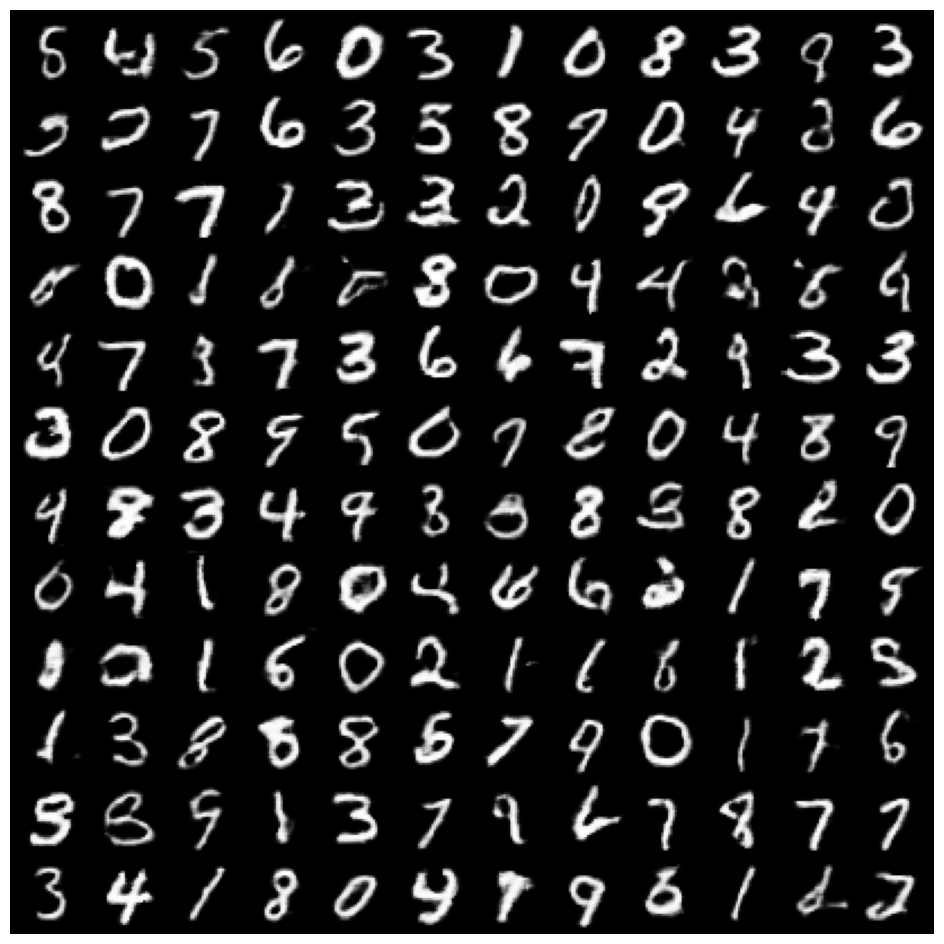

In [10]:
# === 5. Generation and Visualization 12x12 ===

import torch

G = Generator(z_dim=latent_dim, img_channels=channels).to(device)
G.load_state_dict(torch.load("wgan_gp_mnist_ckpt.pt")['generator'])

@torch.no_grad()
def generate_grid(generator, nrow=12, ncol=12, z_dim=latent_dim, device=device, figsize=(12, 12)):
    generator.eval()
    n = nrow * ncol
    z = torch.randn(n, z_dim, 1, 1, device=device)
    fake = generator(z).cpu()

    # Convert to [0, 1] and create grid
    grid = make_grid(fake, nrow=nrow, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Example call after training
generate_grid(G)

# Примудрости GAN

## $f-$дивергенция

Выше мы выводили $GAN$ для $JSD$, теперь для расстояния Вассерштейна, а может ли быть так, что это все частные записи какой-то дивергенции записанной в общем виде?

Да, существует понятие $f-$дивергенции, мы не будем вводить строгое определение, но при некоторых условиях на функцию $f$, мы можем получить, что многие дивергенции можно записать как $D_f(\pi \| p):= \mathbb{E}_{p(x)} f(\frac{\pi}{p})$. Пример $GAN$ с разными функциями $f$ [f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization
](https://arxiv.org/abs/1606.00709)

